# Quantum Neural Networks

## Overview
In this walkthrough, we will look at how Qiskit Runtime enables us to seamlessly run quantum neural network (QNN) implementations and integrate those into basic quantum machine learning (QML) workflows. The classes ``SamplerQNN`` and ``EstimatorQNN`` provided in the module `qiskit-machine-learning` present the necessary "bridge" we need to leverage the full potential of Qiskit Runtime in this context, especially the advantages in coherent execution and effortless Error Mitigation. 

Let us briefly look at the concept of Quantum Neural Networks in general and proceed to show how those can be executed via Qiskit Runtime. 

## Introduction

### Quantum vs. Classical Neural Networks

The motivation behind quantum machine learning (QML) is to integrate notions from quantum computing and classical machine learning to open the way for new and improved learning schemes. QNNs apply this generic principle by combining classical neural networks and parametrized quantum circuits. Because they lie at an intersection between two fields, QNNs can be viewed from two perspectives:

- From a **machine learning perspective**, QNNs are algorithmic models that can be trained to find hidden patterns in data. These models can **load** classical data (**inputs**) into a quantum state, and later **process** it with quantum gates parametrized by **trainable weights**. The figure below shows a generic QNN example including the data loading and processing steps. The output from measuring this state can then be plugged into a loss function to train the weights through backpropagation.

- From a **quantum computing perspective**, QNNs are quantum algorithms based on parametrized quantum circuits that can be trained in a variational manner using classical optimizers. These circuits contain a **feature map** (with input parameters) and an **ansatz** (with trainable weights), as seen in the image below.

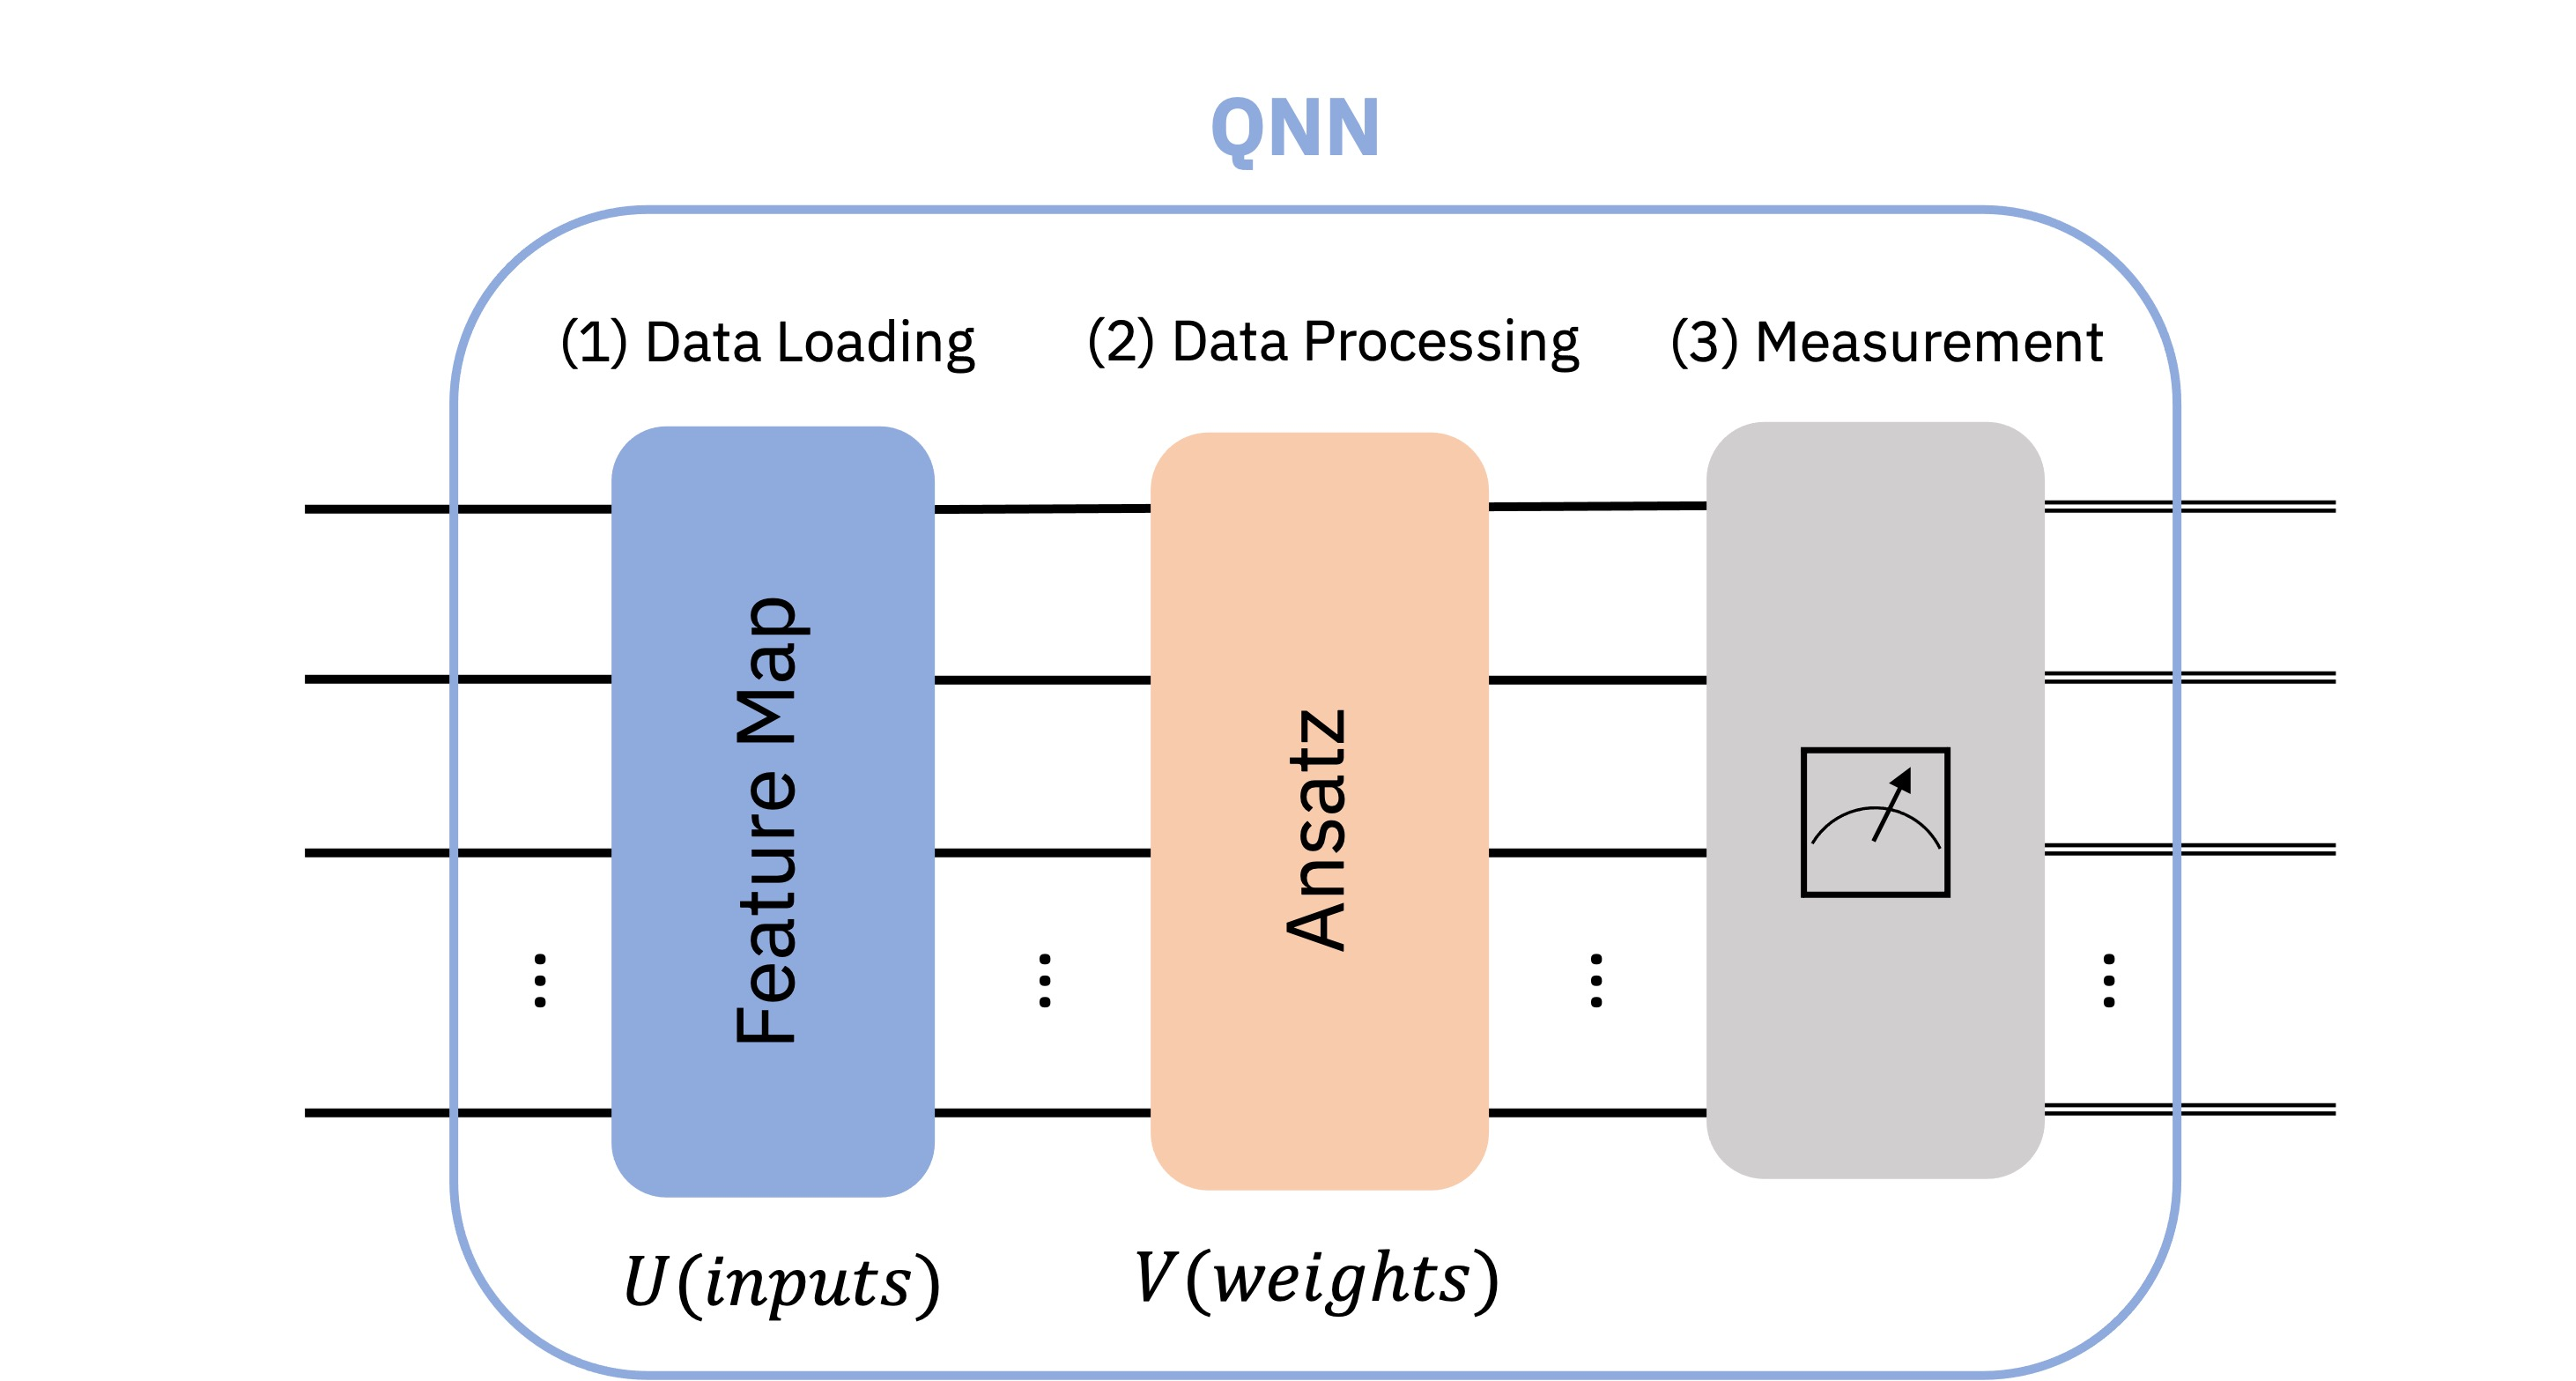


*Figure 1. Generic quantum neural network (QNN) structure.*

As you can see, these two perspectives are complementary, and do not necessarily rely on strict definitions of concepts such as "quantum neuron" or what constitutes a QNN's "layer".

### Implementation in `qiskit-machine-learning`

The QNNs in `qiskit-machine-learning` are meant as computational units that can be used for different use cases, and their setup will depend on the application they are needed for. The module contains an interface for the QNNs and two specific implementations:

1. [NeuralNetwork](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.NeuralNetwork.html): The interface for neural networks. This is an abstract class all QNNs inherit from.
2. [EstimatorQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.EstimatorQNN.html): A network based on the evaluation of quantum mechanical observables.
3. [SamplerQNN](https://qiskit.org/documentation/machine-learning/locale/fr_FR/stubs/qiskit_machine_learning.neural_networks.SamplerQNN.html): A network based on the samples resulting from measuring a quantum circuit.


These implementations are based on the [Qiskit Primitives](https://qiskit.org/documentation/apidoc/primitives.html). The Primitives are the entry point to run QNNs on either a simulator or real quantum hardware. Each implementation, `EstimatorQNN` and `SamplerQNN`, takes in an optional instance of its corresponding primitive.

The `NeuralNetwork` class is the interface for all QNNs available in `qiskit-machine-learning`.
It exposes a forward and a backward pass that take data samples and trainable weights as input.

It's important to note that `NeuralNetwork`s are "stateless". They do not contain any training capabilities (these are pushed to the actual algorithms or applications: [classifiers](https://qiskit.org/documentation/machine-learning/apidocs/qiskit_machine_learning.algorithms.html#classifiers), [regressors](https://qiskit.org/documentation/machine-learning/apidocs/qiskit_machine_learning.algorithms.html#regressors), etc), nor do they store the values for trainable weights.

***

Let's now look into specific examples for the two `NeuralNetwork` implementations. But first, let's set the algorithmic seed to ensure that the results don't change between runs.

In [1]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 42

## How to Instantiate QNNs

We will look at both QNN classes for Estimator and Sampler Primitives here briefly, before we just focus on the SamplerQNN for clarity.

### `EstimatorQNN`

The `EstimatorQNN` takes in a parametrized quantum circuit as input, as well as an optional quantum mechanical observables, and outputs expectation value computations for the forward pass. 

Let's see an `EstimatorQNN` in action with a simple example. We start by constructing the parametrized circuit. This quantum circuit has two parameters, one represents a QNN input and the other represents a trainable weight:

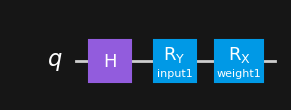

In [2]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

params1 = [Parameter("input1"), Parameter("weight1")]
qc1 = QuantumCircuit(1)
qc1.h(0)
qc1.ry(params1[0], 0)
qc1.rx(params1[1], 0)
qc1.draw("mpl")

We can now create an observable to define the expectation value computation. If not set, then the `EstimatorQNN` will automatically create the default observable $Z^{\otimes n}$. Here, $n$ is the number of qubits of the quantum circuit.

In this example, we will change things up for demonstration purposes and use the $Y^{\otimes n}$ observable:

In [3]:
from qiskit.quantum_info import SparsePauliOp

observable1 = SparsePauliOp.from_list([("Y" * qc1.num_qubits, 1)])

Together with the quantum circuit defined above, and the observable we have created, the `EstimatorQNN` constructor takes in the following keyword arguments:

- `estimator`: optional primitive instance
- `input_params`: list of quantum circuit parameters that should be treated as "network inputs"
- `weight_params`: list of quantum circuit parameters that should be treated as "network weights"

In this example, we previously decided that the first parameter of `params1` should be the input, while the second should be the weight. As we do not specify a Primitive by the `estimator` parameter, we are performing a local statevector simulation by default. The network will create an instance of the reference `Estimator` primitive for us. If we want to access other resources such as the Qiskit Runtime Primitives, we would have to define the respective `Estimator` instances and pass them to the `EstimatorQNN`.

In [4]:
from qiskit_machine_learning.neural_networks import EstimatorQNN

estimator_qnn = EstimatorQNN(
    circuit=qc1, observables=observable1, input_params=[params1[0]], weight_params=[params1[1]]
)
estimator_qnn

### Connect to Qiskit Runtime

In order to leverage the potentials of Qiskit Runtime, we simply need to get one of the Qiskit Runtime Primitives, namely the Estimator and pass it to the `estimator` argument in `EstimatorQNN`

We start by gathering the service that enables our Runtime access as well as the Estimator Primitive from Qiskit Runtime

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator
service = QiskitRuntimeService()

Next up, we open a Session, make sure to run it on a simulator to test our settings and pass this Session to the Estimator Primitive

In [59]:
from qiskit_ibm_runtime import Session
estimator_sim_session=Session(backend='ibmq_qasm_simulator')
runtime_estimator_simulator = Estimator(session=estimator_sim_session)

Then, this Primitive is passed to the EstimatorQNN, where we now explicitly set the `estimator` argument

In [6]:
from qiskit_machine_learning.neural_networks import EstimatorQNN

estimator_qnn = EstimatorQNN(

    estimator=runtime_estimator_simulator,
    circuit=qc1, observables=observable1, input_params=[params1[0]], weight_params=[params1[1]]
)
estimator_qnn

So we have created an Estimator-based QNN that leverages Qiskit Runtime when it is executed. We'll see how to actually put a QNN to use in the following sections, but before that, let's check out the `SamplerQNN` class.

### `SamplerQNN`

The `SamplerQNN` is instantiated in a similar way to the `EstimatorQNN`, but because it directly consumes samples from measuring the quantum circuit, it does not require a custom observable.

These output samples are interpreted by default as the probabilities of measuring the integer index corresponding to a bitstring. However, the `SamplerQNN` also allows us to specify an `interpret` function to post-process the samples. This function should be defined so that it takes a measured integer (from a bitstring) and maps it to a new value, i.e. non-negative integer.

<!-- **(!)** It's important to note that if a custom `interpret` function is defined, the `output_shape` cannot be inferred by the network, and **needs to be provided explicitly**.

**(!)** It's also important to keep in mind that if no `interpret` function is used, the dimension of the probability vector will scale exponentially with the number of qubits. With a custom `interpret` function, this scaling can change. If, for instance, an index is mapped to the parity of the corresponding bitstring, i.e., to 0 or 1, the result will be a probability vector of length 2 independently of the number of qubits. -->

Let's create a different quantum circuit for the `SamplerQNN`. In this case, we will have two input parameters and four trainable weights that parametrize a  two-local circuit.

input parameters: ['input[0]', 'input[1]']
weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]']


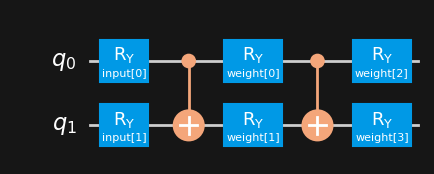

In [7]:
from qiskit.circuit import ParameterVector

inputs2 = ParameterVector("input", 2)
weights2 = ParameterVector("weight", 4)
print(f"input parameters: {[str(item) for item in inputs2.params]}")
print(f"weight parameters: {[str(item) for item in weights2.params]}")

qc2 = QuantumCircuit(2)
qc2.ry(inputs2[0], 0)
qc2.ry(inputs2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[0], 0)
qc2.ry(weights2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[2], 0)
qc2.ry(weights2[3], 1)

qc2.draw(output="mpl")

Similarly to the `EstimatorQNN`, we must specify inputs and weights when instantiating the `SamplerQNN`. In this case, the keyword arguments will be:
- `sampler`: optional primitive instance
- `input_params`: list of quantum circuit parameters that should be treated as "network inputs"
- `weight_params`: list of quantum circuit parameters that should be treated as "network weights"

Please note that here we are choosing not to set the `Sampler` instance to the QNN and relying on the default local statevector simulation.

In [8]:
from qiskit_machine_learning.neural_networks import SamplerQNN

sampler_qnn = SamplerQNN(circuit=qc2, input_params=inputs2, weight_params=weights2)
sampler_qnn

In addition to the basic arguments shown above, the `SamplerQNN` accepts three more settings: `input_gradients`, `interpret`, and `output_shape`, which will look at later in this walkthrough.

## How to Run a Forward Pass

### Set-Up
In a real setting, the inputs would be defined by the dataset, and the weights would be defined by the training algorithm or as part of a pre-trained model. However, to focus on introducing the functionality here, we will specify random sets of input and weights of the right dimension:

#### `SamplerQNN` Example

In [9]:
sampler_qnn_input = algorithm_globals.random.random(sampler_qnn.num_inputs)
sampler_qnn_weights = algorithm_globals.random.random(sampler_qnn.num_weights)

In [10]:
print(
    f"Number of input features for SamplerQNN: {sampler_qnn.num_inputs} \nInput: {sampler_qnn_input}"
)
print(
    f"Number of trainable weights for SamplerQNN: {sampler_qnn.num_weights} \nWeights: {sampler_qnn_weights}"
)

Number of input features for SamplerQNN: 2 
Input: [0.77395605 0.43887844]
Number of trainable weights for SamplerQNN: 4 
Weights: [0.85859792 0.69736803 0.09417735 0.97562235]


Once we have the inputs and the weights, let us run a Forward Pass, which means that we will process the input data through the QNN and look at the measured outcomes.

#### `SamplerQNN` Example

For the `SamplerQNN` the default output shape for the forward pass is `(1, 2**num_qubits)`. With a custom interpret function, the output shape will be `(1, output_shape)`, where `1` in our case is the number of samples:

In [11]:
sampler_qnn_forward = sampler_qnn.forward(sampler_qnn_input, sampler_qnn_weights)

print(
    f"Forward pass result for SamplerQNN: {sampler_qnn_forward}.  \nShape: {sampler_qnn_forward.shape}"
)

Forward pass result for SamplerQNN: [[0.23851185 0.1411135  0.3367757  0.28359895]].  
Shape: (1, 4)


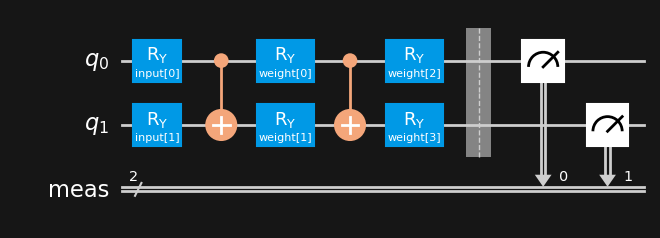

In [12]:
sampler_qnn.circuit.draw()

It is also possible to specify the input in batches, which changes the default output shape for the forward pass to `(batch_size, 2**num_qubits)`. Here we will create a simple batch by specifying the input list twice:

In [13]:
sampler_qnn_forward_batched = sampler_qnn.forward(
    [sampler_qnn_input, sampler_qnn_input], sampler_qnn_weights
)

print(
    f"Forward pass result for SamplerQNN: \n {sampler_qnn_forward_batched}.  \nShape: {sampler_qnn_forward_batched.shape}"
)

Forward pass result for SamplerQNN: 
 [[0.23851185 0.1411135  0.3367757  0.28359895]
 [0.23851185 0.1411135  0.3367757  0.28359895]].  
Shape: (2, 4)


The output shape can also be changed by a custom ``interpret`` function.

## How to Run a Backward Pass

Let's take advantage of the inputs and weights defined above to show how the backward pass works. This pass returns a tuple `(input_gradients, weight_gradients)`. By default, the backward pass will only calculate gradients with respect to the weight parameters.

If you want to enable gradients with respect to the input parameters, you should set the following flag during the QNN instantiation:

```python
qnn = ...QNN(..., input_gradients=True)
```

Please remember that input gradients are **required** for the use of `TorchConnector` for PyTorch integration.

### Backward Pass without Input Gradients

For the `SamplerQNN` (without custom interpret function), the expected output shape for the forward pass is `(batch_size, 2**num_qubits, num_weights)`. With a custom interpret function, the output shape will be `(batch_size, output_shape, num_weights)`.:

In [14]:
sampler_qnn_input_grad, sampler_qnn_weight_grad = sampler_qnn.backward(
    sampler_qnn_input, sampler_qnn_weights
)

print(
    f"Input gradients for SamplerQNN: {sampler_qnn_input_grad}.  \nShape: {sampler_qnn_input_grad}"
)
print(
    f"Weight gradients for SamplerQNN: {sampler_qnn_weight_grad}.  \nShape: {sampler_qnn_weight_grad.shape}"
)

Input gradients for SamplerQNN: None.  
Shape: None
Weight gradients for SamplerQNN: [[[ 0.00609879 -0.30661818 -0.1834591  -0.28341665]
  [-0.02969169  0.17866236  0.1834591  -0.20004909]
  [-0.37812738  0.30266095 -0.30904568  0.28341665]
  [ 0.40172028 -0.17470512  0.30904568  0.20004909]]].  
Shape: (1, 4, 4)


### Backward Pass with Input Gradients

Let's enable the `input_gradients` to show what the expected output sizes are for this option.

In [15]:
sampler_qnn.input_gradients = True

For the `SamplerQNN` (without custom interpret function), the expected output shape for the input gradients is `(batch_size, 2**num_qubits, num_inputs)`. With a custom interpret function, the output shape will be `(batch_size, output_shape, num_inputs)`.

In [16]:
sampler_qnn_input_grad, sampler_qnn_weight_grad = sampler_qnn.backward(
    sampler_qnn_input, sampler_qnn_weights
)

print(
    f"Input gradients for SamplerQNN: {sampler_qnn_input_grad}.  \nShape: {sampler_qnn_input_grad.shape}"
)
print(
    f"Weight gradients for SamplerQNN: {sampler_qnn_weight_grad}.  \nShape: {sampler_qnn_weight_grad.shape}"
)

Input gradients for SamplerQNN: [[[ 0.00854017 -0.4260793 ]
  [ 0.29208826  0.08375938]
  [-0.35915753  0.17972714]
  [ 0.05852911  0.16259278]]].  
Shape: (1, 4, 2)
Weight gradients for SamplerQNN: [[[ 0.00609879 -0.30661818 -0.1834591  -0.28341665]
  [-0.02969169  0.17866236  0.1834591  -0.20004909]
  [-0.37812738  0.30266095 -0.30904568  0.28341665]
  [ 0.40172028 -0.17470512  0.30904568  0.20004909]]].  
Shape: (1, 4, 4)


## Classification

We prepare a simple classification dataset to illustrate the following algorithms.

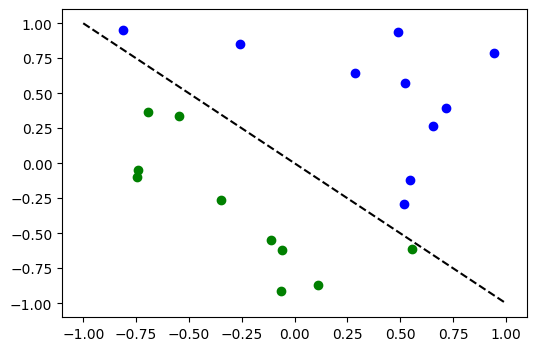

In [40]:
import matplotlib.pyplot as plt
import numpy as np
algorithm_globals.random_seed = 42

num_inputs = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

### Classification with a `SamplerQNN`

Next we show how a `SamplerQNN` can be used for classification within a `NeuralNetworkClassifier`. In this context, the `SamplerQNN` is expected to return $d$-dimensional probability vector as output, where $d$ denotes the number of classes. 
The underlying `Sampler` primitive returns quasi-probability distributions of bit strings and we just need to define a mapping from the measured bitstrings to the different classes. For binary classification we use the parity mapping.

For this example, we will make sure to use the Qiskit Runtime `Sampler`, and start by running the QNN through a Simulator in Runtime

In [50]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session
service = QiskitRuntimeService()

Here is where we specify

In [51]:
sim_session=Session(backend='ibmq_qasm_simulator')
runtime_sampler_simulator = Sampler(session=sim_session)

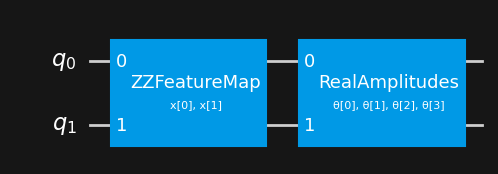

In [52]:
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap

# construct feature map
feature_map = ZZFeatureMap(num_inputs)

# construct ansatz
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
qc.decompose().draw(output="mpl")

In [53]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [54]:
# construct QNN
sampler_qnn_runtime_sim = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    sampler=runtime_sampler_simulator
)

We will add a callback function called `callback_graph`. This will be called for each iteration of the optimizer and will be passed two parameters: the current weights and the value of the objective function at those weights. For our function, we append the value of the objective function to an array so we can plot iteration versus objective function value and update the graph with each iteration. However, you can do whatever you want with a callback function as long as it gets the two parameters mentioned passed. 

In [55]:
from IPython.display import clear_output

# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [56]:
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.algorithms.optimizers import COBYLA

# construct classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn_runtime_sim, optimizer=COBYLA(maxiter=30), callback=callback_graph
)

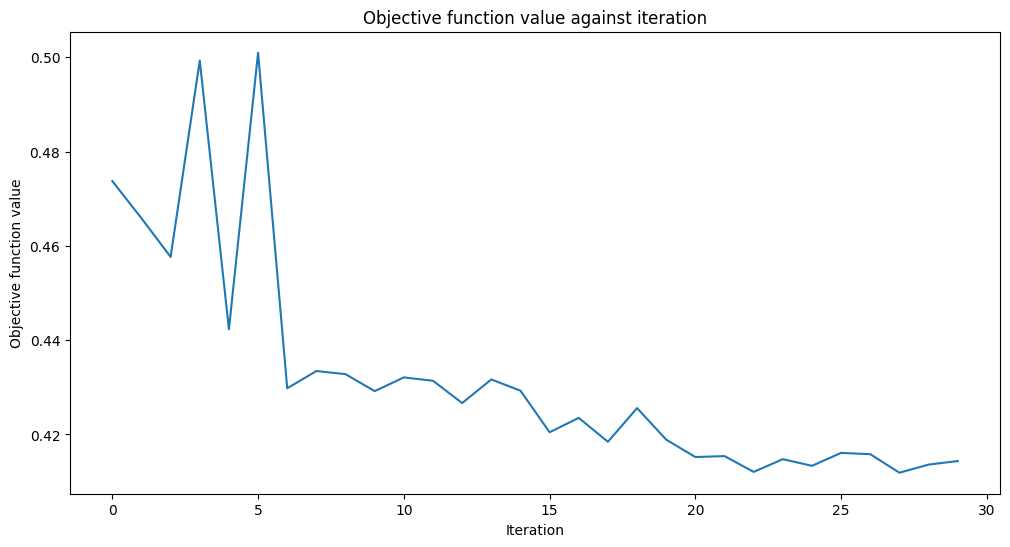

Score: 0.75 (Classification: mean accuracy)


In [57]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
print("Score:",sampler_classifier.score(X, y01),'(Classification: mean accuracy)')

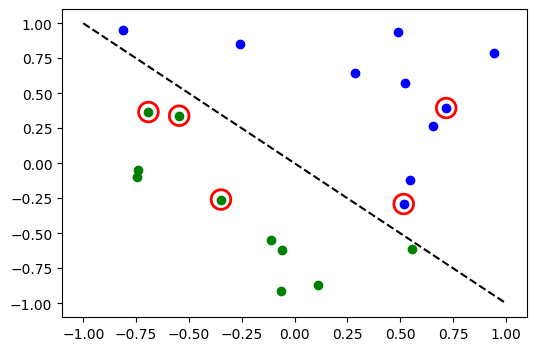

In [58]:
# evaluate data points
y_predict = sampler_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

Once the model is trained we can take a look at the weights.

In [27]:
sampler_classifier.weights

array([ 1.81206546,  1.49931625, -0.36692173, -0.23639463])

### Run on a real QC through Qiskit Runtime

Not that we have seen an exemplary application of a QNN through Qiskit Runtime, let us look at how we can easily do the same on a real quantum computer. In Essence, we just need to change the name of the backend and make sure to pass the Sampler running on that backend to the ``SamplerQNN``

In [ ]:
real_qc_session=Session(backend='ibmq_montreal')
runtime_sampler_realQC = Sampler(session=real_qc_session)

In [ ]:
sampler_qnn_realQC = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    sampler=runtime_sampler_realQC
)

In [ ]:
# construct classifier
sampler_classifier_realQC = NeuralNetworkClassifier(
    neural_network=sampler_qnn_realQC, optimizer=COBYLA(maxiter=30), callback=callback_graph
)

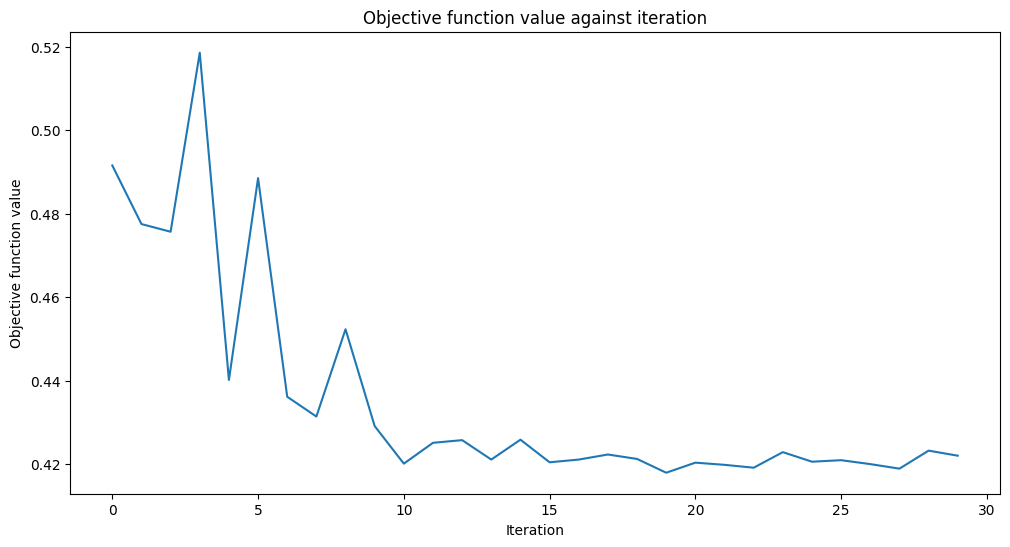

Score (Classification: mean accuracy):  0.75


In [ ]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier_realQC.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
print("Score (Classification: mean accuracy): ",sampler_classifier_realQC.score(X, y01))

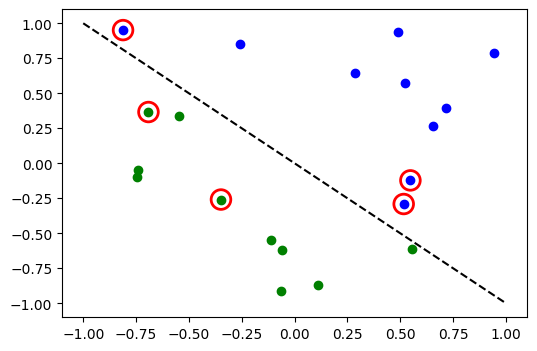

In [ ]:
# evaluate data points
y_predict = sampler_classifier_realQC.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

## Conclusion

In this code walkthrough, we introduced the two neural networks classes provided by `qiskit-machine-learning`, namely the `EstimatorQNN` and `SamplerQNN`, which extend the base `NeuralNetwork` class. We provided some theoretical background, the key steps for QNN initialization and basic use in forward and backward passes.

We have also seen an exemplary Classification application and saw how leveraging the functionalities of Qiskit Runtime is beneficial for a seamless execution, even on real hardware. We now encourage you to try setting up your own QNN and to see how easy it is to run it on a real quantum computer thanks to Qiskit Runtime.


In [38]:
import qiskit_ibm_runtime
print('qiskit-ibm-runtime Version',qiskit_ibm_runtime.__version__)

qiskit-ibm-runtime Version 0.9.1


In [30]:
import qiskit.tools.jupyter

%qiskit_version_table